In [1]:
import os
import numpy as np
import pandas as pd
from pathlib import Path
import matplotlib.pyplot as plt

In [2]:
path = (
    Path.cwd().parent /
    'workflow' /
    'pypsa-earth' /
    'data' /
    'p100_h0'
)

In [3]:
os.listdir(path)

['Average_Electric_Energy_Output_MWhyear.tif',
 'Average_OPEX_cUSDkW-h.tif',
 'Average_Thermal_Energy_Output_MWhyear.tif',
 'Target_Depth_m.tif',
 'Total_CAPEX_USDmm.tif']

In [10]:
import rasterio
from rasterio.transform import xy
import geopandas as gpd
import pandas as pd
import numpy as np
from shapely.geometry import Point


def get_raster_file(tif_file):

    # Open the raster file
    with rasterio.open(tif_file) as src:
        # Read the first band (assuming single-band raster)
        band1 = src.read(1)
        # Get the affine transformation
        transform = src.transform
        # Get the dimensions
        rows, cols = band1.shape

        # Create a meshgrid of row and column indices
        row_indices, col_indices = np.meshgrid(np.arange(rows), np.arange(cols), indexing='ij')
        # Flatten the arrays
        row_indices = row_indices.flatten()
        col_indices = col_indices.flatten()
        band1 = band1.flatten()

        # Filter out nodata values
        nodata = src.nodata
        valid_mask = band1 != nodata
        band1 = band1[valid_mask]
        row_indices = row_indices[valid_mask]
        col_indices = col_indices[valid_mask]

        # Convert row and column indices to x and y coordinates
        xs, ys = xy(transform, row_indices, col_indices)
        
        # Create a DataFrame
        df = pd.DataFrame({
            'value': band1,
            'x': xs,
            'y': ys
        })

        # Create point geometries
        geometry = [Point(xy) for xy in zip(df['x'], df['y'])]
        # Create a GeoDataFrame

        return gpd.GeoDataFrame(df, geometry=geometry, crs=src.crs)


capex_file = path / 'Total_CAPEX_USDmm.tif'
gen_file = path / 'Average_Electric_Energy_Output_MWhyear.tif'
opex_file = path / 'Average_OPEX_cUSDkW-h.tif'

capex_gdf = get_raster_file(capex_file).set_index(['x', 'y']).rename(columns={'value': 'capex'})
gen_gdf = get_raster_file(gen_file).set_index(['x', 'y']).rename(columns={'value': 'gen'})
opex_gdf = get_raster_file(opex_file).set_index(['x', 'y']).rename(columns={'value': 'opex'})

# capex_gdf = get_raster_file(capex_file).rename(columns={'value': 'capex'})
# capex_gdf.index = capex_gdf['geometry']
# gen_gdf = get_raster_file(gen_file).set_index(['geometry']).rename(columns={'value': 'gen'})

In [11]:
total = capex_gdf[['capex', 'geometry']].join(gen_gdf[['gen']], how='inner')
total = total.join(opex_gdf[['opex']], how='inner')

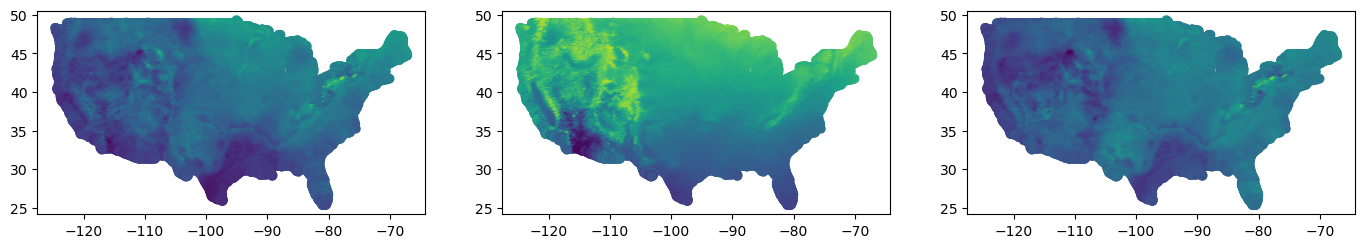

In [13]:
fig, axs = plt.subplots(1, 3, figsize=(17, 10))

total.plot(column='capex', ax=axs[0])
total.plot(column='gen', ax=axs[1])
total.plot(column='opex', ax=axs[2])

plt.show()

In [14]:
total['opex'].mean()

1.9397696

In [7]:
total['plant_capacity'] = total['gen'].div(8760)
total['cleaned_capex($/kWel)'] = total['capex'].div(total['plant_capacity']).mul(1e3)
total['plant_capacity(GWel)'] = total['plant_capacity'].mul(1e-3)

In [8]:
regions = Path.cwd().parent / 'workflow' / 'pypsa-earth' / 'resources' / 'US_2021' / 'bus_regions' / 'regions_onshore_elec_s_10.geojson'
regions = gpd.read_file(regions).set_index('name')

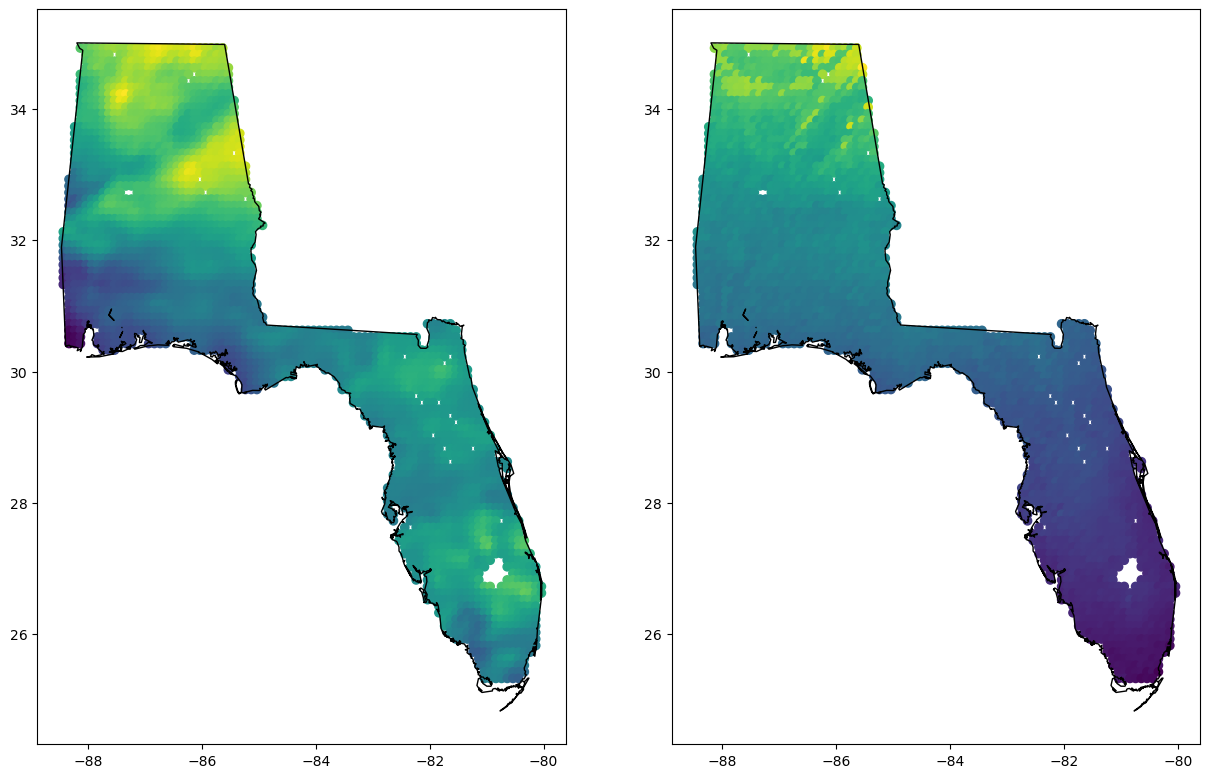

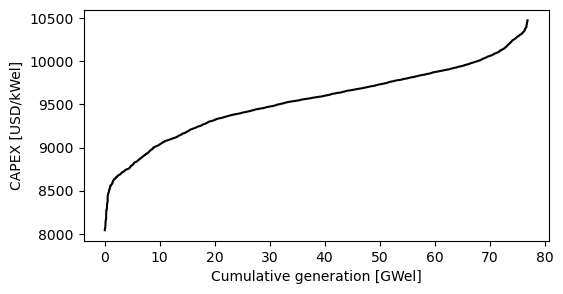

In [9]:
x_supply = 'plant_capacity(GWel)'
y_supply = 'cleaned_capex($/kWel)'

curve_steps = 10


for i, (name, geom) in enumerate(regions.geometry.items()):

    ss = total[total.within(geom)]

    fig, axs = plt.subplots(1, 2, figsize=(15, 10))

    ss.plot(column='capex', ax=axs[0])
    ss.plot(column='gen', ax=axs[1])

    regions.loc[[name]].plot(ax=axs[0], color='none', edgecolor='black')
    regions.loc[[name]].plot(ax=axs[1], color='none', edgecolor='black')

    plt.show()

    supply_curve = ss[[
        'gen',
        'capex',
        x_supply,
        y_supply
        ]].sort_values(y_supply, ascending=True)

    supply_curve['cum_'+x_supply] = supply_curve[x_supply].cumsum()

    fig, ax = plt.subplots(figsize=(6, 3))

    ax.plot(supply_curve['cum_'+x_supply], supply_curve[y_supply], color='k')
    ax.set_xlabel('Cumulative generation [GWel]')
    ax.set_ylabel('CAPEX [USD/kWel]')

    plt.show()

    bins = pd.Series(
            np.linspace(
                ss['capex[$/kW]'].min(),
                ss['capex[$/kW]'].max(),
                curve_steps + 1
                )
            )

ss = supply_curve[['cum_'+x_supply, y_supply]].copy()
print(ss.shape)

    ss['agg_available_capacity[MW]'] = ss['available_capacity[MW]'].cumsum()
    ss['level'] = pd.cut(ss['capex[$/kW]'], bins=bins, labels=labels)







    print('===========================================')

    break